Done by Jovita Andrews
SUID: 522110149

## Aligning AI With Shared Human Values

> Based on the ["Aligning AI With Shared Human Values" classification task](https://github.com/hendrycks/ethics) by Dan Hendrycks, Collin Burns, Steven Basart, Andrew Critch, Jerry Li, Dawn Song, and Jacob Steinhardt, published at ICLR 2021.



### Step 1: Setup and Installing Dependencies
In this step, we'll install the necessary packages for our work to help load the pre-trained models, tokenize the input, and run the classification task.

In [1]:
!pip install torch transformers

### Step 2: Importing the packages

Next, let's import PyTorch to handle our deep learning models, and Hugging Face's transformers for loading BERT.

We'll also be using pandas for handling CSV files, sklearn for data splitting, and numpy for numerical operations:

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np

### Step 3: Loading the Dataset

In [3]:
train_df = pd.read_csv("https://researchjt.s3.us-east-2.amazonaws.com/deontology_train.csv")
test_df = pd.read_csv("https://researchjt.s3.us-east-2.amazonaws.com/deontology_test.csv")

train_df['combined'] = train_df['scenario'] + ' ' + train_df['excuse']
test_df['combined'] = test_df['scenario'] + ' ' + test_df['excuse']


### Step 4: Preparing the Dataset for Training




In [4]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    train_df['combined'], train_df['label'], test_size=0.15, random_state=42)

### Step 5: Creating a Dataset Class

We will use this class to convert our tokenized inputs into a format that can be used with PyTorch's DataLoader, which allows for easy batching and sampling of the data.

In [5]:
class EthicsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        assert len(self.encodings['input_ids']) == len(self.labels), "Encoding and labels length mismatch."

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

### Step 6: Tokenizing the Data and Calculating Maximum Token Length

We will tokenize the training and test data, and calculate the maximum number of tokens in the training set. This will help us adjust the `max_length` parameter to avoid processing unnecessary padding tokens, and make the training process more efficient.

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['combined'].tolist(), truncation=False, padding=False)
train_token_lengths = [len(enc) for enc in train_encodings['input_ids']]
max_tokens = max(train_token_lengths)
print(f"Maximum number of tokens in the training set: {max_tokens}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Maximum number of tokens in the training set: 50


In [7]:
adjusted_max_length = min(max_tokens, 512)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=adjusted_max_length)
valid_encodings = tokenizer(valid_texts.tolist(), truncation=True, padding=True, max_length=adjusted_max_length)
test_encodings = tokenizer(test_df['combined'].tolist(), truncation=True, padding=True, max_length=adjusted_max_length)

train_labels = train_labels.tolist()
valid_labels = valid_labels.tolist()
test_labels = test_df['label'].tolist()

### Step 7: Loading the Data with DataLoader

The DataLoader is used to create iterable datasets for training and validation. It batches the data and allows shuffling in the training data for better performance.

In [8]:
train_dataset = EthicsDataset(train_encodings, train_labels)
valid_dataset = EthicsDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

### Step 8: Model Initialization and Training

In [9]:
from tqdm import tqdm
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # Train for 3 epochs
    print(f"Epoch {epoch+1}/3")
    model.train()
    total_loss = 0
    total_acc = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        # Move batch data to the same device as the model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Calculate accuracy directly here
        _, predicted = torch.max(logits, dim=1)
        correct = (predicted == labels).float().sum()
        acc = correct / labels.size(0)

        total_acc += acc.item()
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), accuracy=acc.item())

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    print(f"Training Loss: {avg_loss}, Training Accuracy: {avg_acc}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training Loss: 0.47284253372633755, Training Accuracy: 0.7729168849543107
Epoch 2/3


Training Loss: 0.27313944857475186, Training Accuracy: 0.8928071713644611
Epoch 3/3


Training Loss: 0.17980843074311895, Training Accuracy: 0.9342251085052805


### Step 9: Evaluating the Model on the Test Set

Once training is complete, we will evaluate the model's performance on the test set by calculating the accuracy. This will give us an idea of how well the model generalizes to unseen data.

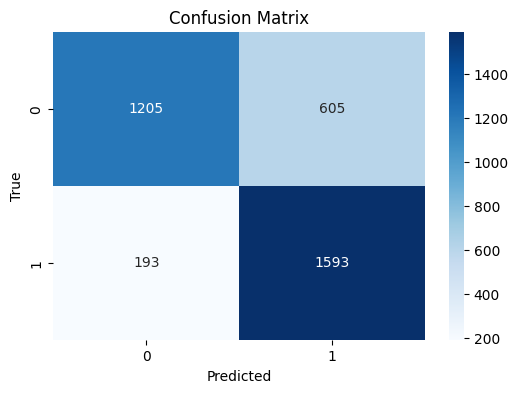

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.67      0.75      1810
     Class 1       0.72      0.89      0.80      1786

    accuracy                           0.78      3596
   macro avg       0.79      0.78      0.78      3596
weighted avg       0.79      0.78      0.78      3596

AUC: 0.8905


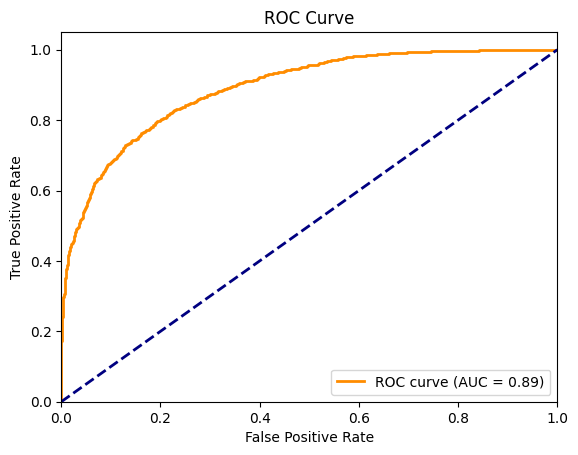

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

test_dataset = EthicsDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model.eval()


all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}

        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)  # Get the class with the highest score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Step 3: Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Calculate precision, recall, F1-score
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

# Step 5: Compute ROC curve and AUC score
probs = []
all_labels_roc = []
with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits

        # Apply softmax to get probability scores for each class
        softmax = torch.nn.Softmax(dim=1)
        probs_batch = softmax(logits)[:, 1]  # Get the probabilities for class 1

        probs.extend(probs_batch.cpu().numpy())
        all_labels_roc.extend(batch['labels'].cpu().numpy())

# Calculate AUC
auc = roc_auc_score(all_labels_roc, probs)
print(f'AUC: {auc:.4f}')

# Generate ROC curve
fpr, tpr, _ = roc_curve(all_labels_roc, probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Your Task
After completing all the code blocks in the notebook, please offer a brief reflection on the following question (doesn't have to be more than 3-4 sentences):

* Is this form of "alignment" training enough to ensure that large language models can "understand" the difference between "right" and "wrong"?

This is an open-ended discussion, and your response does not need to be technical; there is no simple answer to this question, so feel free to explore different perspectives and concepts from class, including your personal opinion.



My answer:
Not at all By training these models, we are unable to clearly distinguish between good and bad since AI models are pattern-driven and do not understand human values, subtleties, or ethical conventions. As a result, the model makes decisions based more on chance than on moral principles. They are unable to see the bigger picture. Ultimately, they lack the cognitive awareness to understand moral dilemmas the way humans do.